In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Dataset
paths = []
labels = []
label_map = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
for dirname, _, filenames in os.walk('../RAVDESS_Audio_Speech_Actors_01-24'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('-')[2]
        label = label_map[label]
        labels.append(label.lower())
    if len(paths) == 2800:
        break

print(labels[:10])
print('Dataset is Loaded')

['neutral', 'neutral', 'neutral', 'neutral', 'calm', 'calm', 'calm', 'calm', 'calm', 'calm']
Dataset is Loaded


In [3]:
len(paths), len(labels)

(1440, 1440)

In [4]:
paths[:5], labels[:5]

(['../RAVDESS_Audio_Speech_Actors_01-24\\Actor_01\\03-01-01-01-01-01-01.wav',
  '../RAVDESS_Audio_Speech_Actors_01-24\\Actor_01\\03-01-01-01-01-02-01.wav',
  '../RAVDESS_Audio_Speech_Actors_01-24\\Actor_01\\03-01-01-01-02-01-01.wav',
  '../RAVDESS_Audio_Speech_Actors_01-24\\Actor_01\\03-01-01-01-02-02-01.wav',
  '../RAVDESS_Audio_Speech_Actors_01-24\\Actor_01\\03-01-02-01-01-01-01.wav'],
 ['neutral', 'neutral', 'neutral', 'neutral', 'calm'])

In [5]:
# Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,../RAVDESS_Audio_Speech_Actors_01-24\Actor_01\...,neutral
1,../RAVDESS_Audio_Speech_Actors_01-24\Actor_01\...,neutral
2,../RAVDESS_Audio_Speech_Actors_01-24\Actor_01\...,neutral
3,../RAVDESS_Audio_Speech_Actors_01-24\Actor_01\...,neutral
4,../RAVDESS_Audio_Speech_Actors_01-24\Actor_01\...,calm


In [6]:
df['label'].value_counts()

label
calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

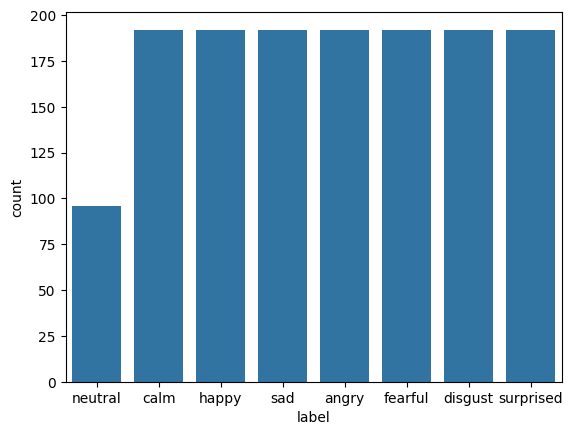

In [7]:
sns.countplot(data=df, x='label')

In [8]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

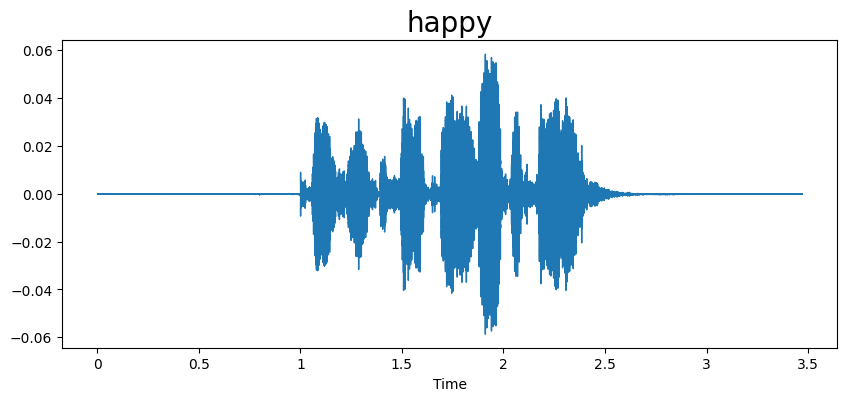

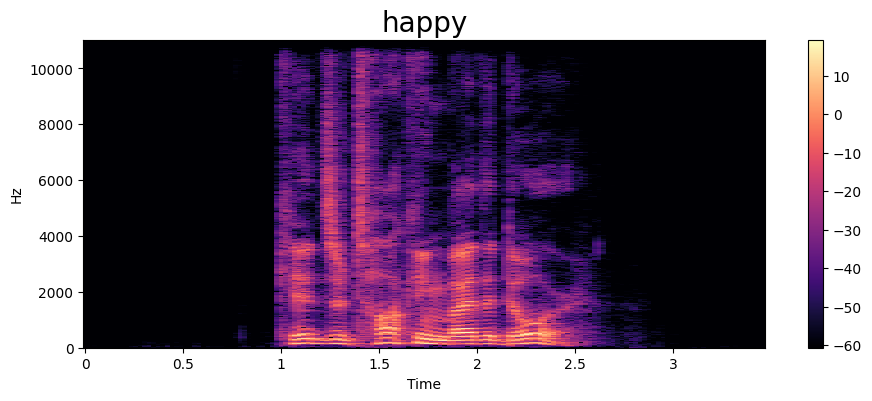

In [9]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [61]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=2.4, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T
    return mfcc

In [62]:
extract_mfcc(df['speech'][10])

array([[-9.46737732e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.46737732e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.44136536e+02,  3.66772413e+00,  3.63487554e+00, ...,
        -3.21665347e-01, -2.95776844e-01, -2.65896916e-01],
       ...,
       [-4.60708344e+02,  1.12948555e+02, -3.43861341e+00, ...,
        -4.52677536e+00, -1.08405437e+01, -4.10197353e+00],
       [-4.73422668e+02,  1.45353821e+02, -2.78018212e+00, ...,
        -5.65316868e+00, -5.33166075e+00, -8.49880028e+00],
       [-4.67365631e+02,  1.38023331e+02,  1.15437040e+01, ...,
        -2.86190462e+00, -3.42082644e+00, -5.52790260e+00]], dtype=float32)

In [63]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [64]:
print(X_mfcc[0].shape)

(104, 40)


In [66]:
X = [x for x in X_mfcc]

In [68]:
length = []
for i, arr in enumerate(X):
    if arr.shape[0] not in length:
        length.append(arr.shape[0]) 
    # print(f"Array {i}: shape={arr.shape}")
print(length)

[104]


In [69]:
X = np.array(X)
X.shape

(1440, 104, 40)

In [70]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [71]:
y = y.toarray()

In [72]:
y.shape

(1440, 8)

In [73]:
enc.categories_

[array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad',
        'surprised'], dtype=object)]

In [74]:
# LSTM Model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify=y)

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(104,40)),
    Flatten(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       304,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 345,800 (1.32 MB)

 Trainable params: 345,800 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, mode='min')

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.1657 - loss: 2.0979 - val_accuracy: 0.2778 - val_loss: 1.9250
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.2334 - loss: 1.9499 - val_accuracy: 0.3924 - val_loss: 1.7297
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.2971 - loss: 1.8186 - val_accuracy: 0.3785 - val_loss: 1.6128
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.3845 - loss: 1.6127 - val_accuracy: 0.4340 - val_loss: 1.5278
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.3660 - loss: 1.6022 - val_accuracy: 0.4062 - val_loss: 1.5052
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.4292 - loss: 1.4955 - val_accuracy: 0.4549 - val_loss: 1.4935
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.4366 - loss: 1.4853 - val_accuracy: 0.4826 - val_loss: 1.4435
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.4472 - loss: 1.4295 - val_accu

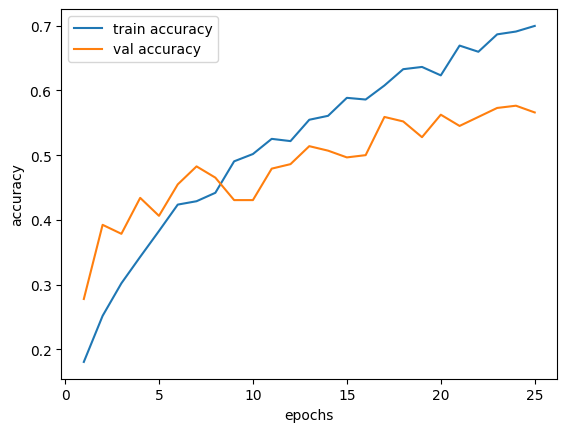

In [76]:
epochs = range(1, len(history.history['accuracy'])+1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

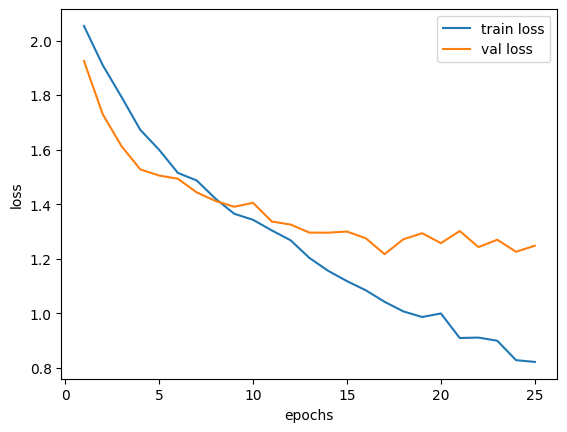

In [77]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [78]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

accuracy_score(y_true, y_pred), cm

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


(0.5659722222222222,
 array([[25,  1,  4,  0,  3,  0,  2,  3],
        [ 0, 35,  0,  0,  1,  0,  2,  0],
        [ 5,  3, 18,  2,  3,  3,  3,  2],
        [ 2,  0,  0, 19,  7,  0,  3,  8],
        [ 4,  1,  2,  4, 19,  0,  4,  5],
        [ 0,  7,  0,  0,  1,  7,  4,  0],
        [ 0, 11,  2,  3,  4,  5, 12,  1],
        [ 0,  0,  4,  4,  0,  0,  2, 28]], dtype=int64))

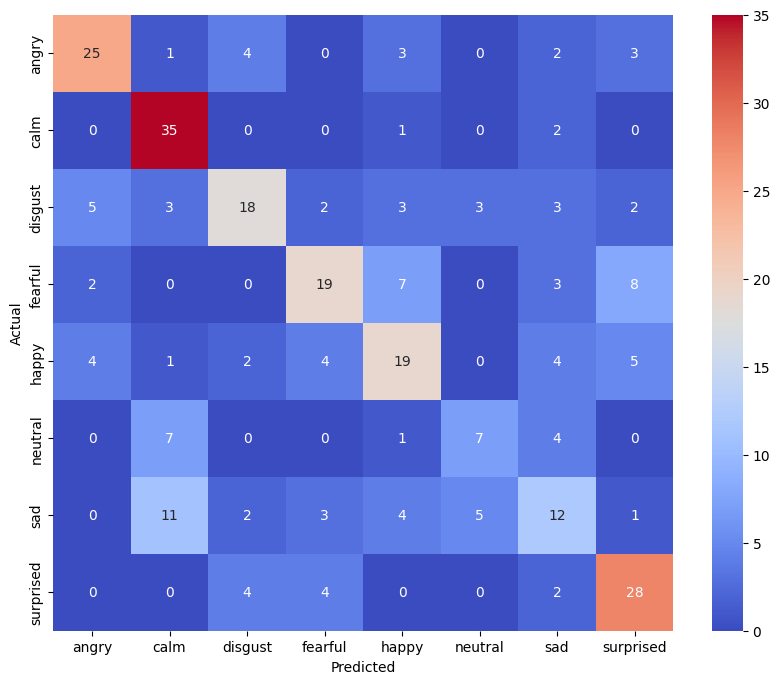

In [79]:
# print colorful confusion matrix
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=enc.categories_[0], yticklabels=enc.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()